# Statical Analysis of Rain (Vancouver vs. Toronto)
The purpose of this analysis is to assess if it rains more in Vancouver than Toronto. To determine if it does rain more, statistical analysis will be used to identify if the amount of rain is statistically different.

In [1]:
# import libraries
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Weather Data
Weather data is from http://climate.weather.gc.ca/. See additional notesbooks for how to read data from web.

In [2]:
path <- "/Users/samedwardes/Documents/GitHub/Vancouver-Weather/data/daily_weather.csv"
df <-  read_csv(path)
names(df) <- make.names(names(df))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_integer(),
  `Date/Time` = col_date(format = ""),
  Year = col_integer(),
  Month = col_integer(),
  Day = col_integer(),
  `Max Temp (°C)` = col_double(),
  `Min Temp (°C)` = col_double(),
  `Mean Temp (°C)` = col_double(),
  `Heat Deg Days (°C)` = col_double(),
  `Cool Deg Days (°C)` = col_double(),
  `Total Rain (mm)` = col_double(),
  `Total Snow (cm)` = col_double(),
  `Total Precip (mm)` = col_double(),
  `Snow on Grnd (cm)` = col_double(),
  `Snow on Grnd Flag` = col_logical(),
  `Dir of Max Gust (10s deg)` = col_double(),
  `Current Station Operator` = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Elevation = col_integer()
  # ... with 1 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)

## Statistical Analysis (Daily)
The purpose of this analysis is to assess if it really does rain more in Vancouver than in Toronto. We will using the following assumptions:
* Ho: van_precip = to_precip
* Ha: van_precip > to_precip

Based on the data, we will determine if we have enough evidence to reject the Null Hypothesis that it rains the same amount in Toronto as Vancouver.

Lets first look at the macro level. Does it rain more in Vancouver or Toronto?

Warning message:
“Removed 478 rows containing missing values (position_stack).”

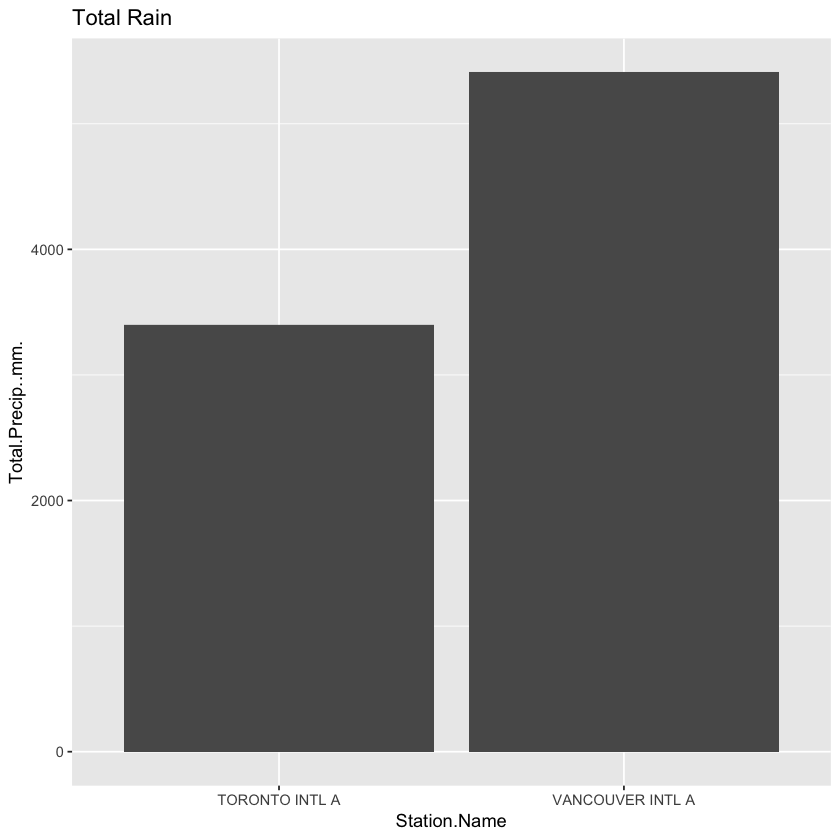

In [3]:
g <- ggplot(df, aes(x=Station.Name, y=Total.Precip..mm.)) + 
    geom_bar(stat="identity") + 
    labs(title='Total Rain')

g

As the barchart above shows, overall it rains more in Vancouver. Is this difference statistically significant though?

### Step 1: Data Prep
Create a new dataframe that compares daily precipitation in Toronto and Vancouver

In [4]:
# create a single column dataframe with all dates
df_precip <- data.frame(unique(df$Date.Time))
colnames(df_precip) <- c("Date.Time")

# join the Vancouver precipitation data
df_van <- df %>% filter(Station.Name == 'VANCOUVER INTL A')
df_precip <- df_precip %>%
    left_join(x = df_precip,
              y = select(df_van, Date.Time, Total.Precip..mm.Van = Total.Precip..mm.),
              by = c("Date.Time", "Date.Time"))

# join the Toronto precipitation data
df_to <- df %>% filter(Station.Name == 'TORONTO INTL A')
df_precip <- df_precip %>%
    left_join(x = df_precip,
              y = select(df_to, Date.Time, Total.Precip..mm.To = Total.Precip..mm.),
              by = c("Date.Time", "Date.Time"))

# calculate the delta
df_precip$Delta  <- df_precip$Total.Precip..mm.Van - df_precip$Total.Precip..mm.To

# view the new dataframe
df_precip <- drop_na(df_precip)
head(df_precip)

Date.Time,Total.Precip..mm.Van,Total.Precip..mm.To,Delta
2015-01-01,0.0,0.0,0.0
2015-01-02,3.8,0.6,3.2
2015-01-03,2.8,10.8,-8.0
2015-01-04,38.0,6.8,31.2
2015-01-05,20.0,0.8,19.2
2015-01-06,0.0,0.4,-0.4


### Step 2: T Test
Run a T test to test the hypothesis that it does not rain more in Vancouver

In [5]:
x_bar <- mean(df_precip$Delta)
x_s <- sd(df_precip$Delta)
n <- length(df_precip$Delta)
x_se <- x_s/sqrt(n)
x_qt <- qt(.975, n-1)

data.frame("Name" = c("x_bar","x_s", "n", "x_se", "x_qt"),
          "Result" = c(x_bar, x_s, n, x_se, x_qt))

# Formula to calculate manually
# x_bar + c(-1,1) * qt(.975, n-1) * x_s/sqrt(n)

precip_t_test <- t.test(x = df_precip$Delta, alternative = 'two.sided', var.equal = FALSE)
precip_t_test


Name,Result
x_bar,1.2417248
x_s,8.5036053
n,1577.0000000
x_se,0.2141348
x_qt,1.9614704



	One Sample t-test

data:  df_precip$Delta
t = 5.7988, df = 1576, p-value = 8.055e-09
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.8217057 1.6617439
sample estimates:
mean of x 
 1.241725 


#### Interpretation of t-test results:
* **p-value of 8.055e-09**: this is very small, so if the null hypothesis were to be true, the observation is very unlikely. Using an alpha of 5%, we would *reject the null hypothesis* because the P-value < alpha.
* **test statistic of 5.7988**: our test statistic is large, much bigger than the 97.5% quantile for the t-distribution (1.96). Therefore, we would *reject the null hypothesis*.
* **95% confidence interval of 0.8217 to 1.6617**: the 95% CI does not contain the 0 (the null hypothesis), therefore we would *reject the null hypothesis*.

The plot below shows us a histogram of the deltas (Vancouver - Toronto precipitation)

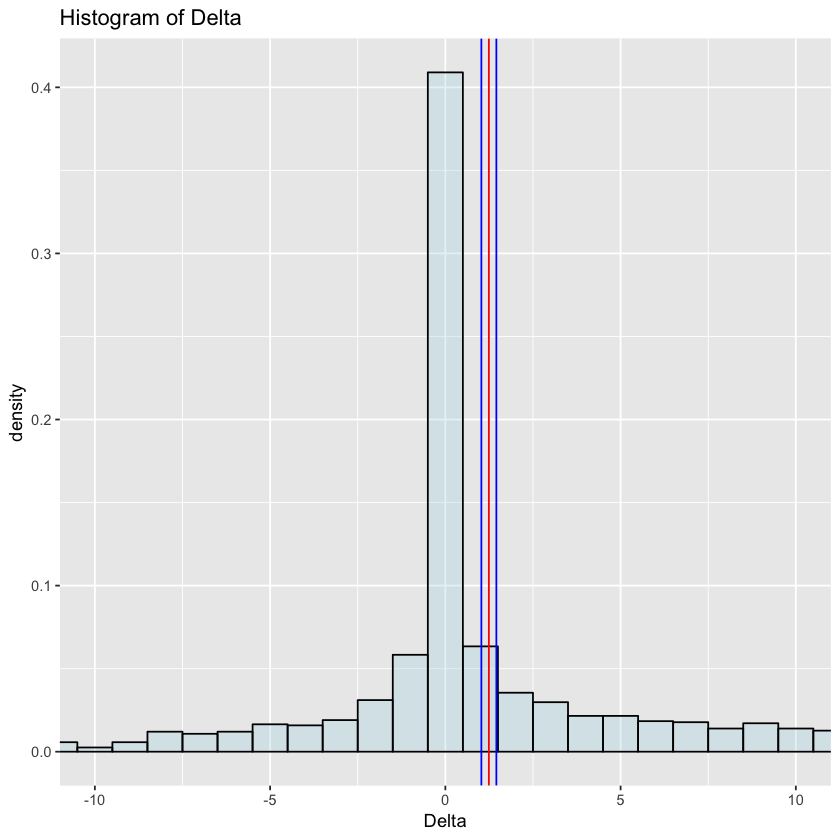

In [6]:
g <- ggplot(df_precip, aes(x=Delta)) + 
    geom_histogram(aes(y=..density..), color='black', fill = 'lightblue',binwidth = 1, alpha = 0.3) +
    coord_cartesian(xlim = c(-10,10)) +
    # geom_density(alpha = 0.1, fill='red') +
    labs(title='Histogram of Delta') +
    geom_vline(xintercept = x_bar, col='red') + # mean
    geom_vline(xintercept = x_bar + x_se, col='blue') + # upper bound CI
    geom_vline(xintercept = x_bar - x_se, col='blue') # lower bound CI
g

The blue lines represent the 95% confidence interval. The red line represents the mean. As can be seen, the low end of the confidence interval lies above the null hypothesis the mean = 0.

## Statistical Analysis (Weekly)
Our original analysis looked at the delta on a daily basis. What if we look at the delta on a monthly basis. Will that change the results?

### Step 1: Data Prep
Create a new dataframe that compares daily precipitation in Toronto and Vancouver

In [7]:
# add a month column
df_precip$Month <- lubridate::month(df_precip$Date.Time)
df_precip$Year <- lubridate::year(df_precip$Date.Time)

# group by the month column
df_precip_monthly <- df_precip %>%
    group_by(Year, Month) %>%
    summarise(Total.Precip..mm.Van = sum(Total.Precip..mm.Van), Total.Precip..mm.To = sum(Total.Precip..mm.To), Delta = sum(Delta))

head(df_precip_monthly)

Year,Month,Total.Precip..mm.Van,Total.Precip..mm.To,Delta
2015,1,123.0,31.4,91.6
2015,2,111.8,31.2,80.6
2015,3,157.2,14.3,142.9
2015,4,51.4,78.8,-27.4
2015,5,4.2,62.8,-58.6
2015,6,11.0,160.2,-149.2


### Step 2: T Test
Run a T test to test the hypothesis that it does not rain more in Vancouver

In [8]:
x_bar <- mean(df_precip_monthly$Delta)
x_s <- sd(df_precip_monthly$Delta)
n <- length(df_precip_monthly$Delta)
x_se <- x_s/sqrt(n)
x_qt <- qt(.975, n-1)

data.frame("Name" = c("x_bar","x_s", "n", "x_se", "x_qt"),
          "Result" = c(x_bar, x_s, n, x_se, x_qt))

# Formula to calculate manually
# x_bar + c(-1,1) * qt(.975, n-1) * x_s/sqrt(n)

precip_t_test <- t.test(x = df_precip_monthly$Delta, alternative = 'two.sided', var.equal = FALSE)
precip_t_test


Name,Result
x_bar,36.947170
x_s,81.634758
n,53.000000
x_se,11.213396
x_qt,2.006647



	One Sample t-test

data:  df_precip_monthly$Delta
t = 3.2949, df = 52, p-value = 0.001777
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 14.44584 59.44850
sample estimates:
mean of x 
 36.94717 


#### Interpretation of t-test results:
* **p-value of 0.00177**: this is very small, so if the null hypothesis were to be true, the observation is very unlikely. Using an alpha of 5%, we would *reject the null hypothesis* because the P-value < alpha.
* **test statistic of 3.249**: our test statistic is large, much bigger than the 97.5% quantile for the t-distribution (1.96). Therefore, we would *reject the null hypothesis*.
* **95% confidence interval of 14.445 to 59.55880**: the 95% CI does not contain the 0 (the null hypothesis), therefore we would *reject the null hypothesis*.

The plot below shows us a histogram of the deltas (Vancouver - Toronto precipitation)

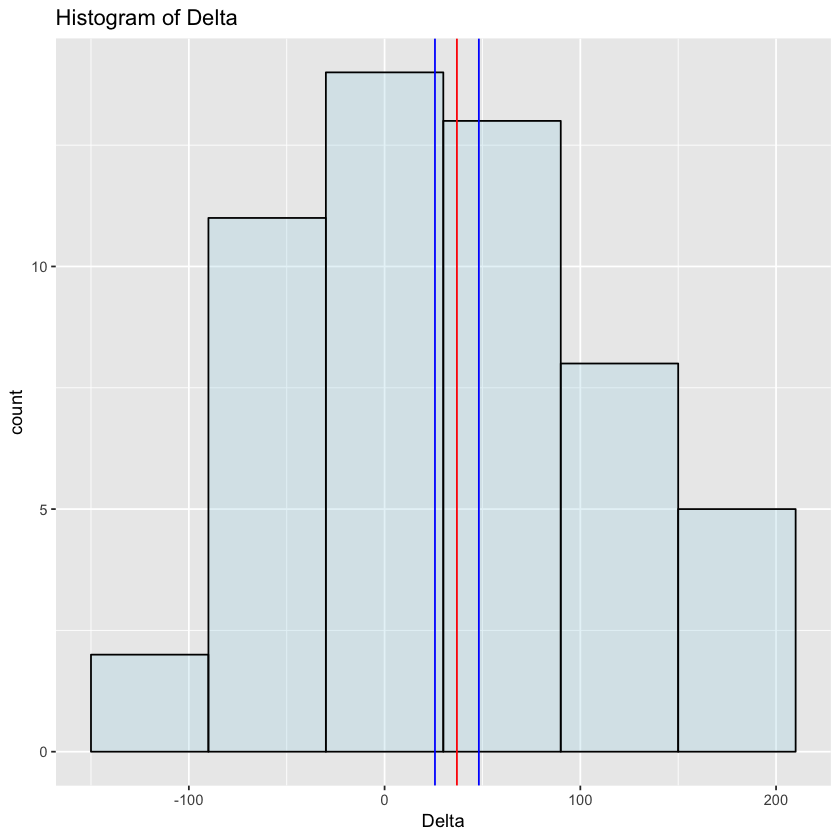

In [9]:
g <- ggplot(df_precip_monthly, aes(x=Delta)) + 
    geom_histogram(binwidth = 60, color='black', fill = 'lightblue', alpha = 0.3) +
    labs(title='Histogram of Delta') +
    geom_vline(xintercept = x_bar, col='red') + # mean
    geom_vline(xintercept = x_bar + x_se, col='blue') + # upper bound CI
    geom_vline(xintercept = x_bar - x_se, col='blue') # lower bound CI

g